In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('./Sarcasm_on_Reddit/train-balanced-sarcasm.csv')
df.dropna(subset=['comment'], inplace=True)
#df = df[0:10000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010771 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010771 non-null  object
 3   subreddit       1010771 non-null  object
 4   score           1010771 non-null  int64 
 5   ups             1010771 non-null  int64 
 6   downs           1010771 non-null  int64 
 7   date            1010771 non-null  object
 8   created_utc     1010771 non-null  object
 9   parent_comment  1010771 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


pattern analysis

In [3]:
# Preprocess the text
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

In [4]:
# Preprocess the parent comments of sarcastic comments
df['parent_tokens'] = df['parent_comment'].apply(preprocess)
sarcastic_parents = df[df['label'] == 1]['parent_tokens']

In [5]:
# transform the tokens list to string for CountVectorizer
sarcastic_parents_str = sarcastic_parents.apply(lambda tokens: ' '.join(tokens))

# Combine all the parent comments into a single string 
corpus = sarcastic_parents_str.tolist()

In [9]:
# Calculate 1-gram frequency in batches
batch_size = 1000
num_batches = len(corpus) // batch_size + 1

word_freq_1gram = {}
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_corpus = corpus[start_idx:end_idx]

    vectorizer_1gram = CountVectorizer(ngram_range=(1, 1))
    X_1gram = vectorizer_1gram.fit_transform(batch_corpus)
    feature_names_1gram = vectorizer_1gram.get_feature_names_out()
    word_counts_1gram = X_1gram.toarray().sum(axis=0)
    batch_word_freq_1gram = dict(zip(feature_names_1gram, word_counts_1gram))

    word_freq_1gram.update(batch_word_freq_1gram)

# Sort the word frequency
sorted_word_freq_1gram = sorted(word_freq_1gram.items(), key=lambda item: item[1], reverse=True)

# Print the top 10 high frequency words
print("Frequent 1-gram words: ", sorted_word_freq_1gram[:10])

Frequent 1-gram words:  [('50v', 57), ('mr', 47), ('g6inory', 42), ('one', 40), ('100v', 35), ('dont', 32), ('like', 32), ('mylar', 32), ('get', 30), ('people', 29)]


In [11]:
# Calculate 2-gram frequency in batches
batch_size = 1000
num_batches = len(corpus) // batch_size + 1

word_freq_2gram = {}
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_corpus = corpus[start_idx:end_idx]

    vectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
    X_2gram = vectorizer_2gram.fit_transform(batch_corpus)
    feature_names_2gram = vectorizer_2gram.get_feature_names_out()
    word_counts_2gram = X_2gram.toarray().sum(axis=0)
    batch_word_freq_2gram = dict(zip(feature_names_2gram, word_counts_2gram))

    word_freq_2gram.update(batch_word_freq_2gram)

# Sort the word frequency
sorted_word_freq_2gram = sorted(word_freq_2gram.items(), key=lambda item: item[1], reverse=True)

# Print the top 10 high frequency words
print("Frequent 2-gram phrases: ", sorted_word_freq_2gram[:10])

Frequent 2-gram phrases:  [('buzzword buzzword', 318), ('venezuela isnt', 142), ('tampon tampon', 125), ('rootkit elevate', 67), ('elevate rootkit', 66), ('shipped 10', 62), ('ordered 10', 62), ('10 shipped', 62), ('admins get', 55), ('fucked admins', 54)]


In [12]:
# Calculate 3-gram frequency in batches
batch_size = 1000
num_batches = len(corpus) // batch_size + 1

word_freq_3gram = {}
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_corpus = corpus[start_idx:end_idx]

    vectorizer_3gram = CountVectorizer(ngram_range=(3, 3))
    X_3gram = vectorizer_3gram.fit_transform(batch_corpus)
    feature_names_3gram = vectorizer_3gram.get_feature_names_out()
    word_counts_3gram = X_3gram.toarray().sum(axis=0)
    batch_word_freq_3gram = dict(zip(feature_names_3gram, word_counts_3gram))

    word_freq_3gram.update(batch_word_freq_3gram)

# Sort the word frequency
sorted_word_freq_3gram = sorted(word_freq_3gram.items(), key=lambda item: item[1], reverse=True)

# Print the top 10 high frequency words
print("Frequent 3-gram phrases: ", sorted_word_freq_3gram[:10])

Frequent 3-gram phrases:  [('buzzword buzzword buzzword', 317), ('around world around', 143), ('world around world', 143), ('venezuela isnt socialist', 142), ('isnt socialist venezuela', 141), ('socialist venezuela isnt', 141), ('tampon tampon tampon', 124), ('elevate rootkit elevate', 66), ('rootkit elevate rootkit', 66), ('10 shipped 10', 62)]


In [13]:
from collections import defaultdict

# Top 10 high frequency words/phrases as patterns
patterns = [item[0] for item in sorted_word_freq_1gram[:10]] + \
           [item[0] for item in sorted_word_freq_2gram[:10]] + \
           [item[0] for item in sorted_word_freq_3gram[:10]]

# Initialize a dictionary to store the counts of each pattern
pattern_counts = defaultdict(lambda: {'total': 0, 'sarcastic': 0})

# Count the occurrence of each pattern in parent comments and the number of sarcastic comments it triggers
for _, row in df.iterrows():
    parent_text = ' '.join(row['parent_tokens']) 
    is_sarcastic = row['label'] == 1
    
    for pattern in patterns:
        if pattern in parent_text:
            pattern_counts[pattern]['total'] += 1
            if is_sarcastic:
                pattern_counts[pattern]['sarcastic'] += 1

# Calculate the sarcastic ratio for each pattern
for pattern, counts in pattern_counts.items():
    counts['sarcastic_ratio'] = counts['sarcastic'] / counts['total'] if counts['total'] > 0 else 0

print("Pattern counts:")
print(pattern_counts)


Pattern counts:
defaultdict(<function <lambda> at 0x0000018B9F113060>, {'get': {'total': 98185, 'sarcastic': 48566, 'sarcastic_ratio': 0.4946376737790905}, 'dont': {'total': 73009, 'sarcastic': 37955, 'sarcastic_ratio': 0.5198674136065417}, 'one': {'total': 166992, 'sarcastic': 83697, 'sarcastic_ratio': 0.5012036504742742}, 'people': {'total': 72304, 'sarcastic': 41947, 'sarcastic_ratio': 0.5801477096702811}, 'like': {'total': 102429, 'sarcastic': 50933, 'sarcastic_ratio': 0.49725175487410794}, 'mr': {'total': 4032, 'sarcastic': 1922, 'sarcastic_ratio': 0.47668650793650796}, 'ordered 10': {'total': 5, 'sarcastic': 4, 'sarcastic_ratio': 0.8}, 'around world around': {'total': 1, 'sarcastic': 1, 'sarcastic_ratio': 1.0}, 'world around world': {'total': 1, 'sarcastic': 1, 'sarcastic_ratio': 1.0}, 'mylar': {'total': 4, 'sarcastic': 2, 'sarcastic_ratio': 0.5}, '100v': {'total': 2, 'sarcastic': 1, 'sarcastic_ratio': 0.5}, 'admins get': {'total': 2, 'sarcastic': 1, 'sarcastic_ratio': 0.5}, 'fuc

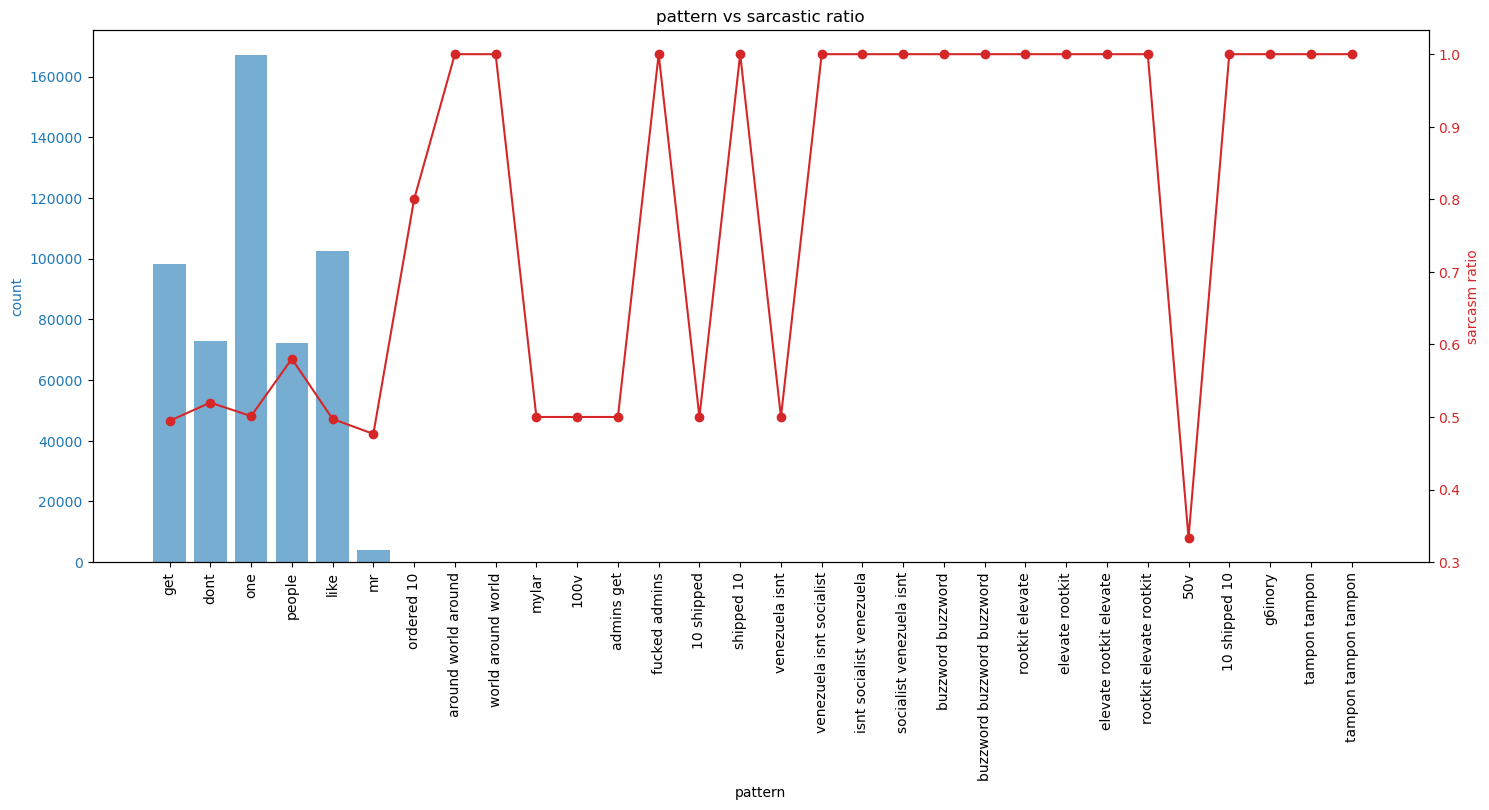

In [14]:
import matplotlib.pyplot as plt

patterns = list(pattern_counts.keys())
total_counts = [pattern_counts[pattern]['total'] for pattern in patterns]
sarcastic_ratios = [pattern_counts[pattern]['sarcastic_ratio'] for pattern in patterns]

# Plot the total count and sarcastic ratio for each pattern
fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('pattern')
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('count', color=color)
ax1.bar(patterns, total_counts, color=color, alpha=0.6, label='total count')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('sarcasm ratio', color=color)
ax2.plot(patterns, sarcastic_ratios, color=color, marker='o', linestyle='-', label='sarcasm ratio')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('pattern vs sarcastic ratio')
plt.show()